In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import Image
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.optimizers import Adam
from tensorflow.keras.metrics import IoU, MeanIoU, MSE, Accuracy
import keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import load_img
import glob
from keras.callbacks import EarlyStopping
from tqdm import tqdm

# Intro
One thing that immediately sticks out is that samples from the same video are not independent. Not a problem for training but suggests a smarter method (if we had more data, longer sequences)

In [2]:
img_dir = 'images/'
mask_dir = 'masks/'

In [3]:
image_files = glob.glob(img_dir+'*')
mask_files = glob.glob(mask_dir+'*')

In [4]:
images = []
masks = []
target_size = (128,128)
for i, img_file in enumerate(image_files):
    img = load_img(img_file, color_mode='rgb', target_size=target_size)
    images.append(img)
    
    mask = load_img(mask_files[i], color_mode='grayscale', target_size=target_size)
    masks.append(mask)

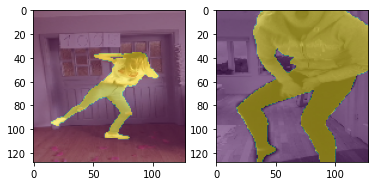

In [5]:
test_idx=1
fig, axes = plt.subplots(1,2)
axes[0].imshow(images[test_idx])
axes[0].imshow(masks[test_idx], alpha=0.5)


axes[1].imshow(images[test_idx+10])
axes[1].imshow(masks[test_idx+10], alpha=0.5)
plt.show()

Check image dimensions and aspect ratios (if heights not all same and widths not all same).

In [6]:
def get_width_height(img):
    height = img.height
    width = img.width
    return height, width

mask_heights, mask_widths = zip(*[get_width_height(mask) for mask in masks])
img_heights, img_widths = zip(*[get_width_height(img) for img in images])

In [7]:
print('Unique image widths:', np.unique(img_widths), '|| Unique mask widths:', np.unique(img_heights))

print('Unique mask widths:', np.unique(mask_widths), '|| Unique mask widths:', np.unique(mask_heights))

Unique image widths: [128] || Unique mask widths: [128]
Unique mask widths: [128] || Unique mask widths: [128]


The widths and heights both only take on one value, so there is no need to worry about cropping inputs, etc. to make all of the images the same size. I do downsize them for memory reasons, however and distort them a bit to downsample them more easily..

# Split Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.1, shuffle=True, random_state=123)

# Augmentation

In [9]:
def rotate_image(img, mask):
    '''
    Rotates an image and associated mask by a random angle
    '''
    angle = np.random.uniform(-180,180)
    img = img.rotate(angle)
    mask = mask.rotate(angle)
    return img, mask

def translate_image(img, mask):
    '''
    Translates an image and associated mask randomly by up to 10 pixels in any direction
    Affine matrix transforms (x, y) --> (ax+by+c, dx+ey+f)
    '''
    a, b, d, e = 1, 0, 0, 1
    c = np.random.uniform(-10,10)
    f = np.random.uniform(-10,10)
    img = img.transform((img.size), Image.AFFINE, (a,b,c,d,e,f))
    mask = mask.transform((img.size), Image.AFFINE, (a,b,c,d,e,f))
    return img, mask

def augmentation(images, masks):
    trans_count = 0
    rot_count = 0
    print(len(images))
    augmented_images, augmented_masks = images.copy(), masks.copy()
    for i, img in enumerate(images):
        # Note some *small* probability of these both being true and still no augmentation
        rotate = bool(np.round(np.random.uniform(0,1)))
        translate = bool(np.round(np.random.uniform(0,1)))
        
        mask = masks[i]
        if rotate:
            img, mask = rotate_image(img, mask)
            rot_count += 1
        if translate:
            img, mask = translate_image(img, mask)
            trans_count += 1
        if translate or rotate:
            augmented_images.append(img)
            augmented_masks.append(mask)
    
    print(f'Rotated {rot_count} images')
    print(f'Translated {trans_count} images')
    return augmented_images, augmented_masks

aug_rounds = 2
for round in range(aug_rounds):
    x_train, y_train = augmentation(x_train, y_train)

2353
Rotated 1142 images
Translated 1163 images
4101
Rotated 2081 images
Translated 2035 images


# Convert Images to Numpy

First, I check the values in the masks.

In [10]:
np.unique([np.asarray(mask) for mask in masks])

array([  0, 255], dtype=uint8)

The "positive" values in the mask are 255. But since the model will be trained using cross entropy, this is very undesirable. Rather, we want the values in the mask to be either 0 or 1. So all of the values in the masks are divided by 255. Similarly, the images are normalized using the same operation.

In [11]:
def data_to_numpy(images, masks):
    images = [np.asarray(img) for img in images]
    masks = [np.asarray(mask) for mask in masks]
    
    return np.asarray(images)/255, np.asarray(masks)/255 

x_train, y_train = data_to_numpy(x_train, y_train)
x_test, y_test = data_to_numpy(x_test, y_test)

# Build Model

In [12]:
def get_model(img_shape):
    inputs = keras.Input(shape=img_shape)
    
    # Downsampler
    # First convolutional block
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs) 
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(64, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_1 = x # first skip connection to be concatenated with last transpose convolution
    x = layers.Conv2D(64, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Second convolutional block
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(128, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_2 = x # second skip connection to be concatenated with third transpose convolution
    x = layers.Conv2D(128, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Third convolutional block
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(256, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_3 = x # second skip connection to be concatenated with second transpose convolution
    x = layers.Conv2D(256, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(512, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_4 = x # second skip connection to be concatenated with first transpose convolution
    x = layers.Conv2D(512, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Fifth convolutional block
    x = layers.Conv2D(1024, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(1024, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)

    # Upsampler
    # First upconv layer
    x = layers.Conv2DTranspose(512, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_4]) 
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    
    # Second upconv layer
    x = layers.Conv2DTranspose(256, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_3])
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    
    # Third upconv layer
    x = layers.Conv2DTranspose(128, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_2])
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)

    # Fourth upconv layer
    x = layers.Conv2DTranspose(64, kernel_size=(2), strides=(2), kernel_initializer='he_normal')(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_1])
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(2, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    outputs = layers.Conv2D(1, kernel_size=(1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [13]:
def get_model_w_pooling(img_shape):
    inputs = keras.Input(shape=img_shape)
    
    # Downsampler
    # First convolutional block
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs) 
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(64, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_1 = x # first skip connection to be concatenated with last transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Second convolutional block
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(128, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_2 = x # second skip connection to be concatenated with third transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Third convolutional block
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(256, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_3 = x # second skip connection to be concatenated with second transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)     
    x = layers.Conv2D(512, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    skip_con_4 = x # second skip connection to be concatenated with first transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Fifth convolutional block
    x = layers.Conv2D(1024, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(1024, kernel_size =(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)

    # Upsampler
    # First upconv layer
    x = layers.Conv2DTranspose(512, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_4]) 
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    
    # Second upconv layer
    x = layers.Conv2DTranspose(256, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_3])
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    
    # Third upconv layer
    x = layers.Conv2DTranspose(128, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_2])
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)

    # Fourth upconv layer
    x = layers.Conv2DTranspose(64, kernel_size=(2), strides=(2), kernel_initializer='he_normal')(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_1])
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    outputs = layers.Conv2D(1, kernel_size=(1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model_w_pooling(x_train[0].shape) # 1 + sigmoid b/c binary
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics='accuracy')
# metrics=CustomMeanIoU(num_classes=len(df)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
es = EarlyStopping(min_delta=0.001, patience=15,restore_best_weights=True)
history = model.fit(x_train, np.expand_dims(y_train, axis=-1), validation_split=0.1, epochs=300, callbacks=[es], batch_size=16)

Epoch 1/300
405/405 [==============================] - 70s 156ms/step - loss: 0.2300 - accuracy: 0.9106 - val_loss: 0.1971 - val_accuracy: 0.9152
Epoch 2/300
405/405 [==============================] - 57s 142ms/step - loss: 0.1419 - accuracy: 0.9416 - val_loss: 0.1453 - val_accuracy: 0.9389
Epoch 3/300
405/405 [==============================] - 58s 143ms/step - loss: 0.1118 - accuracy: 0.9540 - val_loss: 0.1351 - val_accuracy: 0.9415
Epoch 4/300
405/405 [==============================] - 57s 142ms/step - loss: 0.0964 - accuracy: 0.9606 - val_loss: 0.1513 - val_accuracy: 0.9425
Epoch 5/300
405/405 [==============================] - 58s 143ms/step - loss: 0.0821 - accuracy: 0.9664 - val_loss: 0.1240 - val_accuracy: 0.9517
Epoch 6/300
405/405 [==============================] - 58s 142ms/step - loss: 0.0714 - accuracy: 0.9711 - val_loss: 0.0907 - val_accuracy: 0.9629
Epoch 7/300
405/405 [==============================] - 57s 142ms/step - loss: 0.0636 - accuracy: 0.9744 - val_loss: 0.1107 -

In [15]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

9/9 [==============================] - 2s 130ms/step


In [16]:
m = Accuracy()
m.update_state(y_true=y_test, y_pred=y_pred)
iou = m.result().numpy()
print(f'Accuracy of on test set')

Accuracy of on test set


In [17]:
bool_mask=np.where(y_pred == 0, True, False)
masked_preds = np.ma.MaskedArray(y_pred, bool_mask)

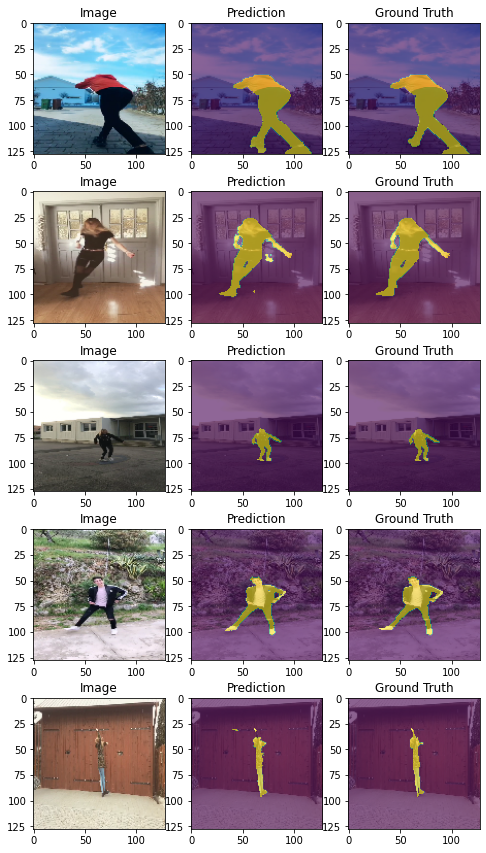

In [19]:
num_examples = 5
fig, axes = plt.subplots(num_examples,3, figsize=(8,15))

for i in range(num_examples):
    test_idx=np.random.randint(0, len(x_test))
    ## Raw image
    axes[i][0].imshow(x_test[test_idx])
    axes[i][0].set_title('Image')
    
    # Predictions
    axes[i][1].imshow(x_test[test_idx])
    axes[i][1].imshow(y_pred[test_idx], alpha=0.6)
    axes[i][1].set_title('Prediction')

    # Ground Truth
    axes[i][2].imshow(x_test[test_idx])
    axes[i][2].imshow(y_test[test_idx], alpha=0.6)
    axes[i][2].set_title('Ground Truth')

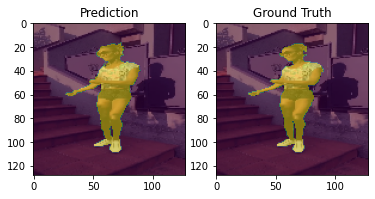

In [18]:
test_idx=1
fig, axes = plt.subplots(1,2)
axes[0].imshow(x_test[test_idx])
axes[0].set_title('Prediction')
axes[0].imshow(y_pred[test_idx], alpha=0.5)


axes[1].imshow(x_test[test_idx])
axes[1].imshow(y_test[test_idx], alpha=0.5)
axes[1].set_title('Ground Truth')
plt.show()

I also test the image below on a random frame I found searching "TikTok dance" on youtube. This is mooyamusunga on TikTok.

In [54]:
def predict_image(img_path):
    img = load_img(img_path, color_mode='rgb', target_size=target_size)
    img = np.asarray(img)/255
    img = np.expand_dims(img, axis=0)
    mask = model.predict(img)[0]
    return mask, img[0]

def plot_image(mask, img):
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(img)
    axes[0].set_title('Prediction')
    axes[0].imshow(mask, alpha=0.5)


    axes[1].imshow(img)
    axes[1].set_title('Image')
    plt.show()

1/1 [==============================] - 0s 15ms/step


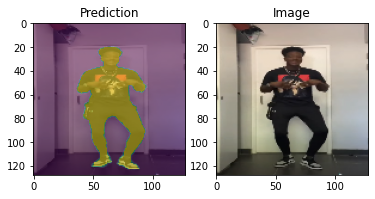

In [55]:
mask, img = predict_image('screenshot example.png')

plot_image(mask, img)

I note that the model was trained on videos containing only one person. I suspect it will have trouble if there are more people in the image. An example is below. These are from the accounts rylenbesler and kennilove03.

1/1 [==============================] - 0s 13ms/step


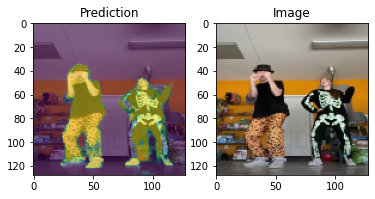

1/1 [==============================] - 0s 12ms/step


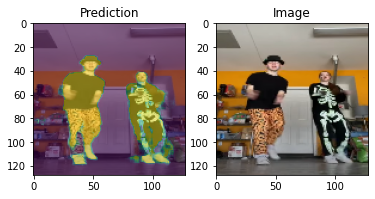

1/1 [==============================] - 0s 12ms/step


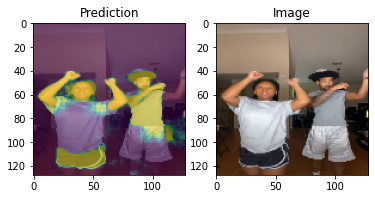

In [56]:
mask, img = predict_image('two_dancers.png')

plot_image(mask, img)

mask, img = predict_image('two_dancers2.png')

plot_image(mask, img)

mask, img = predict_image('two_dancers3.png')

plot_image(mask, img)

Noting that these are just three images, there still seems to be some obvious drop in performance. Given the model was not trained on such images, this is expected.